# Bug triage with Deep Learning

In [1]:
import keras
from tensorflow.contrib.tensorboard.plugins import projector

C:\Users\Thiago\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from __future__ import print_function, division

In [3]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [4]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.initializers import TruncatedNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers

In [5]:
from methods.baseline import Baseline

## Auxiliary methods

## Dataset bugs

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

## Configurações Globais

In [6]:
MAX_SEQUENCE_LENGTH_T = 100 # 40
MAX_SEQUENCE_LENGTH_D = 100 # 200
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000

### Parse bugs preproprecessed

In [7]:
DIR = 'data/processed/eclipse'
DIR_PAIRS = 'data/normalized/eclipse'

In [8]:
df_train_pair = pd.read_csv(os.path.join(DIR_PAIRS, 'eclipse_pairs.csv'))
baseline = Baseline(DIR, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

In [9]:
baseline.load_ids(DIR)

In [10]:
len(baseline.bug_ids)

212512

### Dicionário de títulos e descrições

In [11]:
%%time

baseline.load_preprocess()

100%|█████████████████████████████████| 212512/212512 [09:10<00:00, 385.80it/s]


Wall time: 9min 10s


In [12]:
len(baseline.sentence_dict)

242718

## Geração de batches

### Generating tiple of batches

In [13]:
%%time

bug_dir = os.path.join(DIR)
baseline.prepare_dataset(bug_dir)

Reading train data
Wall time: 642 ms


In [ ]:
baseline.load_bugs()

 22%|███████▍                          | 46634/212512 [01:26<04:16, 647.19it/s]

In [ ]:
%%time

batch_size = 1
batch_size_test = 512

# we want a constant validation group to have a frame of reference for model performance
train_gen = baseline.siam_gen(bug_dir, batch_size, 1)
valid_input_sample, valid_input_pos, valid_input_neg, valid_sim = baseline.batch_iterator(bug_dir, batch_size_test, 1)
test_gen = ([valid_input_sample['title'], valid_input_pos['title'], valid_input_neg['title'], 
             valid_input_sample['description'], valid_input_pos['description'], valid_input_neg['description']], valid_sim)

In [ ]:
valid_input_sample['title'].shape, valid_input_sample['description'].shape, valid_sim.shape

### Validar entrada

In [ ]:
%%time 

baseline.display_batch(bug_dir, 5)

#### Train

## Pre-trained embeddings

Loading pretrained word vectors

### Glove

In [ ]:
%%time

baseline.generating_embed(GLOVE_DIR='data/embed', EMBEDDING_DIM=EMBEDDING_DIM)

## Towards Accurate Duplicate Bug Retrieval Using Deep Learning Techniques

https://github.com/tqtg/DuplicateBugFinder

### CNN with filter 3,4,5

In [30]:
import keras
from keras.layers import GlobalMaxPooling1D 

keras.backend.clear_session()

def cnn_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):

  embedding_layer = Embedding(num_words,
                              embedding_dim,
                              weights=[embeddings],
                              input_length=max_sequence_length,
                              trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length,), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

  # Yoon Kim model (https://arxiv.org/abs/1408.5882)
  convs = []
  filter_sizes = [3,4,5]

  for filter_size in filter_sizes:
      l_conv = Conv1D(filters=32, kernel_size=filter_size, activation='relu')(embedded_sequences)
      l_pool = MaxPooling1D(pool_size=3)(l_conv)
      convs.append(l_pool)

  # l_merge = Merge(mode='concat', concat_axis=1)(convs)

  l_merge = Concatenate(axis=1)(convs)

  # add a 1D convnet with global maxpooling, instead of Yoon Kim model
  conv = Conv1D(filters=64, kernel_size=3, activation='relu')(l_merge)
  pool = GlobalMaxPooling1D()(conv) # pool_size=3
  # Original Yoon Kim model
  #x = Flatten()(pool)
  #x = Dropout(0.5)(x)
  layer = Activation('relu')(pool)

  cnn_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureCNNGenerationModel') # inputs=visible
  
  return cnn_feature_model

### Bi-LSTM

In [31]:
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional

def lstm_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):
  number_lstm_units = 100
  rate_drop_lstm = 0
  recurrent_dropout = 0

  embedding_layer = Embedding(num_words,
                          embedding_dim,
                          weights=[embeddings],
                          input_length=max_sequence_length,
                          trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length, ), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

   # Creating LSTM Encoder
  lstm_layer = Bidirectional(LSTM(number_lstm_units, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm), merge_mode='sum')

  x = lstm_layer(embedded_sequences)

  layer = Activation('relu')(x)

  lstm_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureLstmGenerationModel') # inputs=visible
  
  return lstm_feature_model

### Siamese model

In [141]:
from keras import backend as K
import tensorflow as tf

# https://stackoverflow.com/questions/50673196/keras-triplet-loss-crashes-when-training
class MarginLoss(keras.layers.Layer):
  def call(self, inputs):
    bug_in, bug_pos, bug_neg  = inputs
    loss, dis_pos, dis_neg = self.distance(bug_in, bug_pos, bug_neg)
    self.add_loss(loss, inputs=inputs)
    return  K.stack(inputs)

  def compute_output_shape(self, input_shape):
        return (None, 1)

  def distance(self, bug_in, bug_pos, bug_neg):
    dis_pos, dis_neg = self.cos_distance(bug_in, bug_pos), self.cos_distance(bug_in, bug_neg)
    ep = 1
    d1 = K.maximum(0.0, ep - dis_pos + dis_neg)
    return K.mean(d1), dis_pos, dis_neg
    
  def l2_normalize(self, x, axis):
    norm = K.sqrt(K.sum(K.square(x), axis=axis, keepdims=True))
    return K.maximum(x, K.epsilon()) / K.maximum(norm, K.epsilon())

  # https://github.com/keras-team/keras/issues/3031
  def cos_distance(self, y_true, y_pred):
    y_true = self.l2_normalize(y_true, axis=-1)
    y_pred = self.l2_normalize(y_pred, axis=-1)
    return K.mean(1 - K.sum((y_true * y_pred), axis=-1))
    
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)

# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    margin = K.constant(1.0)
    return K.mean(K.maximum(0, margin - K.square(y_pred[:,0,0])+ K.square(y_pred[:,1,0])))

In [113]:
class myCallback(keras.callbacks.Callback):
    def __init__(self, log_dir = './logs/', margin_loss=None):
        super(myCallback, self).__init__()
        training_log_dir = os.path.join(log_dir, 'training')
        self.summary_writer = tf.summary.FileWriter(training_log_dir)
        self.margin_loss = margin_loss
    #def on_batch_end(self, batch, logs = None):
        #print(batch)
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
#         print(self.model.get_layer('margin_loss_1'))
#         print(dir(self.model.get_layer('margin_loss_1')))
        model = self.model.get_layer('margin_loss_1')
#         summary = tf.Summary()
#         summary_value = summary.value.add()
#         summary_value.simple_value = model.distance_pos
#         summary_value.tag = 'distance_pos'
#         self.summary_writer.add_summary(summary, epoch)
#         self.val_writer.flush()
        super(myCallback, self).on_epoch_end(epoch, logs)

In [142]:
from keras.layers import concatenate, Add, Lambda
from keras.optimizers import Adam

def siamese_model(lstm_feature_model, cnn_feature_model, max_sequence_length_t, max_sequence_length_d):
  
  bug_t_in = Input(shape = (max_sequence_length_t, ), name = 'title_in')
  bug_t_pos = Input(shape = (max_sequence_length_t, ), name = 'title_pos')
  bug_t_neg = Input(shape = (max_sequence_length_t, ), name = 'title_neg')
  
  bug_d_in = Input(shape = (max_sequence_length_d, ), name = 'desc_in')
  bug_d_pos = Input(shape = (max_sequence_length_d, ), name = 'desc_pos')
  bug_d_neg = Input(shape = (max_sequence_length_d, ), name = 'desc_neg')

  bug_t_in_feat_lstm = lstm_feature_model(bug_t_in)
  bug_t_pos_feat_lstm = lstm_feature_model(bug_t_pos)
  bug_t_neg_feat_lstm = lstm_feature_model(bug_t_neg)
  
  bug_d_in_feat_cnn = cnn_feature_model(bug_d_in)
  bug_d_pos_feat_cnn = cnn_feature_model(bug_d_pos)
  bug_d_neg_feat_cnn = cnn_feature_model(bug_d_neg)

  encoded_anchor = concatenate([bug_t_in_feat_lstm, bug_d_in_feat_cnn], name = 'merge_features_in')
  encoded_positive = concatenate([bug_t_pos_feat_lstm, bug_d_pos_feat_cnn], name = 'merge_features_pos')
  encoded_negative = concatenate([bug_t_neg_feat_lstm, bug_d_neg_feat_cnn], name = 'merge_features_neg')
  
  loss = MarginLoss()([encoded_anchor, encoded_positive, encoded_negative])
  
  #adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
  
  similarity_model = Model(inputs = [bug_t_in, bug_t_pos, bug_t_neg, bug_d_in, bug_d_pos, bug_d_neg], 
                           outputs = loss, name = 'Similarity_Model')

  # setup the optimization process 
  similarity_model.compile(optimizer='adam', loss=None) # metrics = ['accuracy']
  
  return similarity_model

## Experiment

In [143]:
%%time
import keras

# Inspired on https://pastebin.com/TaGFdcBA

keras.backend.clear_session()

cnn_feature_model = cnn_model(embeddings=embedding_matrix, 
                              num_words=len(word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_D, 
                              trainable=False)

lstm_feature_model = lstm_model(embeddings=embedding_matrix, 
                              num_words=len(word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_T, 
                              trainable=False)

similarity_model = siamese_model(lstm_feature_model, cnn_feature_model, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

# cnn_feature_model.summary()
# lstm_feature_model.summary()
similarity_model.summary()

#tbCallBack = keras.callbacks.TensorBoard(log_dir='logs/training', histogram_freq=0, write_graph=True, write_images=True)

h = similarity_model.fit_generator(train_gen, 
                               steps_per_epoch = 16,
                               #validation_data=test_gen, # 
                                             epochs = 100,
                                             verbose = True
                                              )  # callbacks=[tbCallBack]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_in (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
desc_in (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
title_pos (InputLayer)          (None, 100)          0                                            
__________________________________________________________________________________________________
desc_pos (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
title_neg 

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257303). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 5s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 10s 608ms/step - loss: 1.0003
Epoch 7/100
 1/16 [>.............................] - ETA: 4s - loss: 1.0002

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.279645). Check your callbacks.
  % delta_t_median)


13/16 [=======================>......] - ETA: 6s - loss: 0.999 - ETA: 6s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.0004

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.278192). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 9s 548ms/step - loss: 1.0003
Epoch 8/100
 1/16 [>.............................] - ETA: 5s - loss: 1.0007

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.292989). Check your callbacks.
  % delta_t_median)


 2/16 [==>...........................] - ETA: 6s - loss: 1.0003

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.424814). Check your callbacks.
  % delta_t_median)


 3/16 [====>.........................] - ETA: 7s - loss: 1.0001

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.328045). Check your callbacks.
  % delta_t_median)


 4/16 [======>.......................] - ETA: 7s - loss: 1.0001

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.310517). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 9s 590ms/step - loss: 1.0001
Epoch 9/100
 1/16 [>.............................] - ETA: 5s - loss: 1.0001

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.333941). Check your callbacks.
  % delta_t_median)


 2/16 [==>...........................] - ETA: 6s - loss: 1.0002

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.383411). Check your callbacks.
  % delta_t_median)


 3/16 [====>.........................] - ETA: 7s - loss: 1.0004

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.338176). Check your callbacks.
  % delta_t_median)


 4/16 [======>.......................] - ETA: 7s - loss: 1.0003

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.342543). Check your callbacks.
  % delta_t_median)


 5/16 [========>.....................] - ETA: 6s - loss: 1.0003

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.346911). Check your callbacks.
  % delta_t_median)


 8/16 [==============>...............] - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.0002

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.336058). Check your callbacks.
  % delta_t_median)


15/16 [===========================>..] - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.0001

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.280807). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - 9s 592ms/step - loss: 1.0001
Epoch 10/100
16/16 [==============================] - ETA: 4s - loss: 1.000 - ETA: 6s - loss: 0.999 - ETA: 5s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 10s 626ms/step - loss: 1.0001
Epoch 11/100
16/16 [==============================] - ETA: 4s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 0.999 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 10s 631ms/step - loss: 1.0001
Epoch 12/100
16/16 [======================

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.287718). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 5s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 3s - loss: 0.999 - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 9s 577ms/step - loss: 1.0003
Epoch 15/100
 1/16 [>.............................] - ETA: 4s - loss: 0.9980

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.382772). Check your callbacks.
  % delta_t_median)


 9/16 [===============>..............] - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.0001

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.278771). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 9s 570ms/step - loss: 1.0000
Epoch 16/100
16/16 [==============================] - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 0.999 - ETA: 2s - loss: 0.999 - ETA: 1s - loss: 0.999 - ETA: 1s - loss: 0.999 - ETA: 0s - loss: 0.999 - 9s 566ms/step - loss: 0.9999
Epoch 17/100
 7/16 [============>.................] - ETA: 24s - loss: 0.99 - ETA: 25s - loss: 1.00 - ETA: 20s - loss: 1.00 - ETA: 16s - loss: 1.00 - ETA: 14s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 9s - loss: 1.0004 

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.261188). Check your callbacks.
  % delta_t_median)


 9/16 [===============>..............] - ETA: 8s - loss: 1.000 - ETA: 6s - loss: 1.0004

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250868). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - 17s 1s/step - loss: 1.0003
Epoch 18/100
12/16 [=====================>........] - ETA: 21s - loss: 0.99 - ETA: 19s - loss: 0.99 - ETA: 17s - loss: 0.99 - ETA: 16s - loss: 1.00 - ETA: 16s - loss: 1.00 - ETA: 15s - loss: 1.00 - ETA: 13s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 9s - loss: 1.0000 - ETA: 8s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 4s - loss: 1.0000

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258811). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - 19s 1s/step - loss: 1.0000
Epoch 19/100
16/16 [==============================] - ETA: 10s - loss: 0.99 - ETA: 10s - loss: 0.99 - ETA: 9s - loss: 0.9998 - ETA: 10s - loss: 1.00 - ETA: 11s - loss: 0.99 - ETA: 10s - loss: 0.99 - ETA: 8s - loss: 0.9999 - ETA: 7s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 3s - loss: 0.999 - ETA: 2s - loss: 0.999 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 12s 772ms/step - loss: 1.0000
Epoch 20/100
16/16 [==============================] - ETA: 4s - loss: 1.000 - ETA: 11s - loss: 1.00 - ETA: 15s - loss: 1.00 - ETA: 15s - loss: 1.00 - ETA: 13s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 9s - loss: 1.0000 - ETA: 8s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 -

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239672). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 11s 657ms/step - loss: 1.0000
Epoch 30/100
11/16 [===================>..........] - ETA: 3s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.0001

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248682). Check your callbacks.
  % delta_t_median)


12/16 [=====================>........] - ETA: 2s - loss: 1.0001

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268194). Check your callbacks.
  % delta_t_median)


15/16 [===========================>..] - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.0001

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.261687). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - 9s 573ms/step - loss: 1.0001
Epoch 31/100
16/16 [==============================] - ETA: 17s - loss: 0.99 - ETA: 20s - loss: 0.99 - ETA: 19s - loss: 0.99 - ETA: 16s - loss: 0.99 - ETA: 14s - loss: 0.99 - ETA: 12s - loss: 0.99 - ETA: 10s - loss: 1.00 - ETA: 8s - loss: 1.0000 - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 15s 938ms/step - loss: 1.0000
Epoch 32/100
16/16 [==============================] - ETA: 24s - loss: 0.99 - ETA: 22s - loss: 0.99 - ETA: 21s - loss: 0.99 - ETA: 20s - loss: 0.99 - ETA: 18s - loss: 0.99 - ETA: 15s - loss: 0.99 - ETA: 14s - loss: 0.99 - ETA: 12s - loss: 0.99 - ETA: 10s - loss: 1.00 - ETA: 8s - loss: 0.9999 - ETA: 7s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 3s - loss: 0.999 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - 19s 1s/step - loss: 0.9999
Epoch 33/100
16/16 [=======================

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240672). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 13s 790ms/step - loss: 1.0000
Epoch 37/100
16/16 [==============================] - ETA: 11s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 9s - loss: 1.0001 - ETA: 8s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 14s 896ms/step - loss: 1.0000
Epoch 38/100
16/16 [==============================] - ETA: 4s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249678). Check your callbacks.
  % delta_t_median)


 7/16 [============>.................] - ETA: 4s - loss: 1.0001

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.259184). Check your callbacks.
  % delta_t_median)


 8/16 [==============>...............] - ETA: 4s - loss: 1.0001

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.260188). Check your callbacks.
  % delta_t_median)


12/16 [=====================>........] - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 1.0000

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.262190). Check your callbacks.
  % delta_t_median)


15/16 [===========================>..] - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.0000

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.265191). Check your callbacks.
  % delta_t_median)
C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.260689). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - 9s 544ms/step - loss: 1.0000
Epoch 46/100
16/16 [==============================] - ETA: 4s - loss: 0.999 - ETA: 4s - loss: 1.000 - ETA: 8s - loss: 1.000 - ETA: 11s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 9s - loss: 1.0000 - ETA: 8s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 15s 937ms/step - loss: 1.0000
Epoch 47/100
16/16 [==============================] - ETA: 6s - loss: 1.000 - ETA: 8s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - 18s 1s/step - loss: 1.0001
Epoch 48/100
16/16 [========================

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247667). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 11s 716ms/step - loss: 1.0001
Epoch 50/100
16/16 [==============================] - ETA: 9s - loss: 0.999 - ETA: 11s - loss: 0.99 - ETA: 10s - loss: 1.00 - ETA: 9s - loss: 0.9999 - ETA: 8s - loss: 0.999 - ETA: 7s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 3s - loss: 0.999 - ETA: 3s - loss: 0.999 - ETA: 2s - loss: 0.999 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 13s 792ms/step - loss: 1.0000
Epoch 51/100
16/16 [==============================] - ETA: 17s - loss: 0.99 - ETA: 21s - loss: 1.00 - ETA: 21s - loss: 1.00 - ETA: 18s - loss: 0.99 - ETA: 14s - loss: 0.99 - ETA: 12s - loss: 0.99 - ETA: 10s - loss: 0.99 - ETA: 9s - loss: 1.0000 - ETA: 7s - loss: 1.000

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268191). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 3s - loss: 0.999 - ETA: 3s - loss: 0.999 - ETA: 2s - loss: 0.999 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 13s 792ms/step - loss: 1.0001
Epoch 57/100
16/16 [==============================] - ETA: 9s - loss: 0.999 - ETA: 10s - loss: 0.99 - ETA: 9s - loss: 0.9997 - ETA: 8s - loss: 0.999 - ETA: 7s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 3s - loss: 0.999 - ETA: 2s - loss: 0.999 - ETA: 2s - loss: 0.999 - ETA: 1s - loss: 0.999 - ETA: 1s - loss: 0.999 - ETA: 0s - loss: 0.999 - 9s 547ms/step - loss: 0.9999
Epoch 58/100
16/16 [==============================] - ETA: 4s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 0.999 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 -

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.284702). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 6s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 5s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 15s 916ms/step - loss: 1.0000
Epoch 60/100
16/16 [==============================] - ETA: 4s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 5s - loss: 0.999 - ETA: 5s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 6s - loss: 0.999 - ETA: 7s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 2s - loss: 0.999 - ETA: 2s - loss: 0.999 - ETA: 1s - loss: 0.999 - 17s 1s/step - loss: 0.9998
Epoch 61/100
16/16 [==============================] - ETA: 9s - loss: 1.000 - ETA: 11s - loss: 1.00 - ETA: 9s - loss: 1.0007 - ETA: 9s - loss: 0.999 - ETA: 9s - loss: 1.000 - E

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235667). Check your callbacks.
  % delta_t_median)


15/16 [===========================>..] - ETA: 0s - loss: 0.9999

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245174). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - 15s 942ms/step - loss: 0.9999
Epoch 67/100
16/16 [==============================] - ETA: 15s - loss: 1.00 - ETA: 15s - loss: 1.00 - ETA: 15s - loss: 1.00 - ETA: 13s - loss: 1.00 - ETA: 13s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 9s - loss: 1.0002 - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - 18s 1s/step - loss: 1.0000
Epoch 68/100
 9/16 [===============>..............] - ETA: 11s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 9s - loss: 1.0000 - ETA: 8s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 0.9999

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232146). Check your callbacks.
  % delta_t_median)


15/16 [===========================>..] - ETA: 3s - loss: 0.999 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 0.999 - ETA: 1s - loss: 0.999 - ETA: 1s - loss: 0.999 - ETA: 0s - loss: 0.9999

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239670). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - 10s 603ms/step - loss: 0.9999
Epoch 69/100
16/16 [==============================] - ETA: 4s - loss: 0.999 - ETA: 10s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 11s - loss: 0.99 - ETA: 10s - loss: 0.99 - ETA: 9s - loss: 0.9999 - ETA: 7s - loss: 0.999 - ETA: 7s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 15s 942ms/step - loss: 1.0000
Epoch 70/100
16/16 [==============================] - ETA: 9s - loss: 1.000 - ETA: 14s - loss: 1.00 - ETA: 16s - loss: 1.00 - ETA: 15s - loss: 1.00 - ETA: 14s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 8s - loss: 1.0000 - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 15s 931ms/step - loss: 1.0000
Epoch 71/100
13/16 [===================

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237670). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 15s 919ms/step - loss: 1.0001
Epoch 72/100
16/16 [==============================] - ETA: 4s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 8s - loss: 1.000 - ETA: 8s - loss: 1.000 - ETA: 8s - loss: 1.000 - ETA: 8s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - 18s 1s/step - loss: 1.0000
Epoch 73/100
 9/16 [===============>..............] - ETA: 4s - loss: 1.000 - ETA: 5s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 3s - loss: 0.999 - ETA: 3s - loss: 1.0000

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246193). Check your callbacks.
  % delta_t_median)


10/16 [=================>............] - ETA: 2s - loss: 1.0000

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248686). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - ETA: 0s - loss: 1.000 - 8s 481ms/step - loss: 0.9999
Epoch 74/100
14/16 [=========================>....] - ETA: 15s - loss: 1.00 - ETA: 15s - loss: 1.00 - ETA: 17s - loss: 1.00 - ETA: 16s - loss: 1.00 - ETA: 15s - loss: 1.00 - ETA: 14s - loss: 1.00 - ETA: 13s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 8s - loss: 1.0001 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.0001

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250180). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 1s - loss: 1.000 - 18s 1s/step - loss: 1.0000
Epoch 75/100
16/16 [==============================] - ETA: 14s - loss: 1.00 - ETA: 17s - loss: 1.00 - ETA: 16s - loss: 1.00 - ETA: 16s - loss: 1.00 - ETA: 15s - loss: 1.00 - ETA: 14s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 8s - loss: 1.0002 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - 19s 1s/step - loss: 1.0001
Epoch 76/100
16/16 [==============================] - ETA: 21s - loss: 0.99 - ETA: 18s - loss: 0.99 - ETA: 17s - loss: 0.99 - ETA: 17s - loss: 0.99 - ETA: 16s - loss: 1.00 - ETA: 14s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 8s - loss: 1.0000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - 18s 1s/step - loss: 1.0000
Epoch 77/100
16/16 [====

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.264768). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 7s - loss: 0.999 - ETA: 8s - loss: 0.999 - ETA: 7s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 15s 919ms/step - loss: 1.0003
Epoch 84/100
 3/16 [====>.........................] - ETA: 5s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 6s - loss: 0.9999

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.297211). Check your callbacks.
  % delta_t_median)


 5/16 [========>.....................] - ETA: 6s - loss: 0.999 - ETA: 5s - loss: 0.9999

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.282198). Check your callbacks.
  % delta_t_median)


 6/16 [==========>...................] - ETA: 5s - loss: 0.9999

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.289705). Check your callbacks.
  % delta_t_median)


 9/16 [===============>..............] - ETA: 4s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 3s - loss: 0.9996

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.262185). Check your callbacks.
  % delta_t_median)


11/16 [===================>..........] - ETA: 3s - loss: 0.999 - ETA: 2s - loss: 0.9997

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.279698). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 2s - loss: 0.999 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 11s 696ms/step - loss: 1.0000
Epoch 85/100
10/16 [=================>............] - ETA: 13s - loss: 1.00 - ETA: 16s - loss: 0.99 - ETA: 17s - loss: 1.00 - ETA: 16s - loss: 1.00 - ETA: 14s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 8s - loss: 1.0004 - ETA: 7s - loss: 1.000 - ETA: 5s - loss: 1.0003

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.272194). Check your callbacks.
  % delta_t_median)


13/16 [=======================>......] - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.0003

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256182). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 13s 799ms/step - loss: 1.0001
Epoch 86/100
16/16 [==============================] - ETA: 3s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 5s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 13s 838ms/step - loss: 1.0001
Epoch 87/100
 3/16 [====>.........................] - ETA: 5s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 6s - loss: 0.9996

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.277199). Check your callbacks.
  % delta_t_median)


 6/16 [==========>...................] - ETA: 6s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 5s - loss: 0.9998

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.266691). Check your callbacks.
  % delta_t_median)


10/16 [=================>............] - ETA: 4s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 3s - loss: 0.999 - ETA: 3s - loss: 1.0001

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238163). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 0.999 - ETA: 0s - loss: 0.999 - 10s 637ms/step - loss: 0.9999
Epoch 88/100
13/16 [=======================>......] - ETA: 15s - loss: 1.00 - ETA: 15s - loss: 1.00 - ETA: 16s - loss: 1.00 - ETA: 16s - loss: 1.00 - ETA: 15s - loss: 1.00 - ETA: 13s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 8s - loss: 1.0001 - ETA: 7s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.0001

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257183). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 2s - loss: 1.000 - ETA: 0s - loss: 1.000 - 16s 1s/step - loss: 1.0001
Epoch 89/100
10/16 [=================>............] - ETA: 19s - loss: 1.00 - ETA: 19s - loss: 1.00 - ETA: 16s - loss: 1.00 - ETA: 14s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 8s - loss: 1.0000 - ETA: 7s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.0001

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233666). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 14s 899ms/step - loss: 1.0001
Epoch 90/100
16/16 [==============================] - ETA: 17s - loss: 1.00 - ETA: 15s - loss: 1.00 - ETA: 14s - loss: 1.00 - ETA: 12s - loss: 0.99 - ETA: 10s - loss: 0.99 - ETA: 9s - loss: 0.9999 - ETA: 7s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 3s - loss: 0.999 - ETA: 2s - loss: 0.999 - ETA: 2s - loss: 0.999 - ETA: 1s - loss: 0.999 - ETA: 0s - loss: 1.000 - 12s 768ms/step - loss: 1.0000
Epoch 91/100
 9/16 [===============>..............] - ETA: 14s - loss: 1.00 - ETA: 13s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 9s - loss: 1.0001 - ETA: 8s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.0000

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252180). Check your callbacks.
  % delta_t_median)


11/16 [===================>..........] - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.0000

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258685). Check your callbacks.
  % delta_t_median)


14/16 [=========================>....] - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.0000

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243173). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 0s - loss: 1.000 - 10s 623ms/step - loss: 1.0000
Epoch 92/100
 6/16 [==========>...................] - ETA: 7s - loss: 0.999 - ETA: 8s - loss: 1.000 - ETA: 8s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 6s - loss: 1.0003

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252680). Check your callbacks.
  % delta_t_median)


 7/16 [============>.................] - ETA: 5s - loss: 1.0002

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.262188). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 14s 869ms/step - loss: 1.0002
Epoch 93/100
 6/16 [==========>...................] - ETA: 9s - loss: 1.000 - ETA: 10s - loss: 0.99 - ETA: 9s - loss: 0.9999 - ETA: 8s - loss: 0.999 - ETA: 7s - loss: 0.999 - ETA: 6s - loss: 0.9998

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250678). Check your callbacks.
  % delta_t_median)


 9/16 [===============>..............] - ETA: 5s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 0.9998

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246174). Check your callbacks.
  % delta_t_median)


10/16 [=================>............] - ETA: 3s - loss: 0.9999

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.248176). Check your callbacks.
  % delta_t_median)


11/16 [===================>..........] - ETA: 2s - loss: 0.9999

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.252681). Check your callbacks.
  % delta_t_median)


14/16 [=========================>....] - ETA: 2s - loss: 0.999 - ETA: 1s - loss: 0.999 - ETA: 1s - loss: 0.9999

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247677). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 0s - loss: 0.999 - 11s 660ms/step - loss: 1.0000
Epoch 94/100
14/16 [=========================>....] - ETA: 11s - loss: 0.99 - ETA: 12s - loss: 0.99 - ETA: 11s - loss: 0.99 - ETA: 10s - loss: 0.99 - ETA: 9s - loss: 0.9996 - ETA: 8s - loss: 0.999 - ETA: 7s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 3s - loss: 0.999 - ETA: 2s - loss: 0.999 - ETA: 1s - loss: 0.999 - ETA: 1s - loss: 0.9999

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241172). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 0s - loss: 0.999 - 12s 724ms/step - loss: 0.9999
Epoch 95/100
16/16 [==============================] - ETA: 10s - loss: 1.00 - ETA: 13s - loss: 0.99 - ETA: 12s - loss: 1.00 - ETA: 11s - loss: 1.00 - ETA: 10s - loss: 0.99 - ETA: 9s - loss: 0.9998 - ETA: 7s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 0.999 - ETA: 3s - loss: 0.999 - ETA: 2s - loss: 0.999 - ETA: 1s - loss: 0.999 - 16s 1s/step - loss: 0.9998
Epoch 96/100
16/16 [==============================] - ETA: 5s - loss: 1.000 - ETA: 7s - loss: 1.001 - ETA: 6s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 8s - loss: 1.000 - ETA: 8s - loss: 1.000 - ETA: 8s - loss: 1.000 - ETA: 7s - loss: 0.999 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - 19s 1s/step - loss: 1.0001
Epoch 97/100
16/16 [==

C:\Users\Thiago\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237169). Check your callbacks.
  % delta_t_median)


16/16 [==============================] - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 15s 950ms/step - loss: 1.0000
Epoch 100/100
16/16 [==============================] - ETA: 7s - loss: 1.000 - ETA: 8s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 7s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - 13s 837ms/step - loss: 1.0001
Wall time: 23min 54s


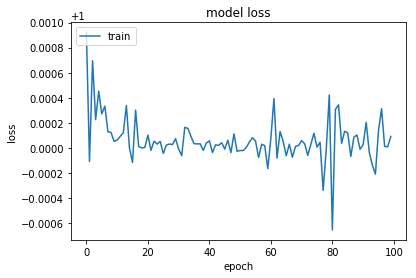

In [144]:
loss=h.history['loss']

plt.plot(loss, label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [147]:
for layer in similarity_model.layers:
    print(layer.name)

title_in
desc_in
title_pos
desc_pos
title_neg
desc_neg
FeatureLstmGenerationModel
FeatureCNNGenerationModel
merge_features_in
merge_features_pos
merge_features_neg
margin_loss_1


In [148]:
## Freeze weights
for layer in similarity_model.layers:
    layer.trainable = False
    
model_in = similarity_model.get_layer('merge_features_in')
model_pos = similarity_model.get_layer('merge_features_pos')
x_in = model_in.output
x_pos = model_pos.output
x = Concatenate()([x_in, x_pos])
x = Dense(64, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
output = Dense(2, activation = 'softmax', name = 'output')(x)
model_clf = Model(inputs=similarity_model.input, outputs=output)
model_clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model_clf.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_in (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
desc_in (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
title_pos (InputLayer)          (None, 100)          0                                            
__________________________________________________________________________________________________
desc_pos (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
FeatureLst

In [151]:
%%time

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

valid_labels = encoder.fit_transform(test_gen[1])
valid_labels = to_categorical(valid_labels)
test_validation = (test_gen[0], valid_labels)

h_clf = model_clf.fit_generator(siam_gen_classification(bug_dir, 512, 1), 
                               steps_per_epoch = 16,
#                                 validation_split=0.2,
                               validation_data=test_validation, # 
                                             epochs = 10,
                                             verbose = True) # callbacks=[early]

Epoch 1/10
16/16 [==============================] - ETA: 13:56 - loss: 3.4186 - acc: 0.50 - ETA: 9:48 - loss: 2.0709 - acc: 0.5000 - ETA: 8:57 - loss: 1.9781 - acc: 0.500 - ETA: 7:30 - loss: 1.9055 - acc: 0.500 - ETA: 6:19 - loss: 1.7549 - acc: 0.500 - ETA: 5:20 - loss: 1.5805 - acc: 0.500 - ETA: 4:29 - loss: 1.4795 - acc: 0.500 - ETA: 3:46 - loss: 1.4331 - acc: 0.500 - ETA: 3:07 - loss: 1.3981 - acc: 0.500 - ETA: 2:33 - loss: 1.3567 - acc: 0.500 - ETA: 2:02 - loss: 1.3073 - acc: 0.500 - ETA: 1:34 - loss: 1.2568 - acc: 0.500 - ETA: 1:07 - loss: 1.2157 - acc: 0.500 - ETA: 43s - loss: 1.1868 - acc: 0.500 - ETA: 20s - loss: 1.1669 - acc: 0.50 - 332s 21s/step - loss: 1.1498 - acc: 0.5002 - val_loss: 0.8362 - val_acc: 0.5000
Epoch 2/10
16/16 [==============================] - ETA: 54s - loss: 0.8343 - acc: 0.50 - ETA: 1:22 - loss: 0.7957 - acc: 0.500 - ETA: 1:27 - loss: 0.7642 - acc: 0.500 - ETA: 1:13 - loss: 0.7485 - acc: 0.499 - ETA: 1:12 - loss: 0.7466 - acc: 0.499 - ETA: 1:01 - loss: 0.

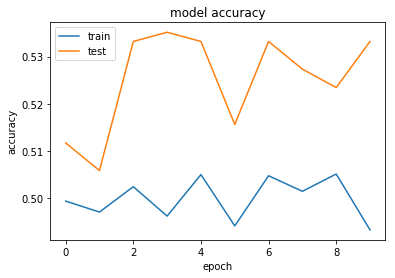

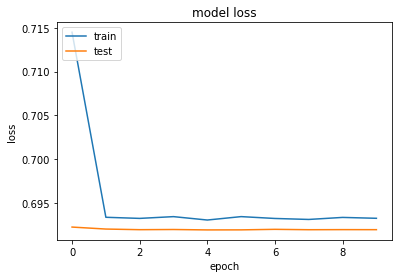

In [323]:
validation_accuracy_loss(h_clf)

In [60]:
name = 'baseline_10epoch_16steps_512batch(test)'
save_model(similarity_model, name)
save_result(h, name)

Saved model to disk
